### Overview of Data Augmentation
#### Why Augment Data?

+ Increase Dataset Variability: By applying random transformations, you can generate new, varied examples from your existing data, effectively **increasing your dataset size without needing additional labeled data**.

+ Improve Generalization: Augmented data helps models learn invariant features (e.g., recognizing an object regardless of its orientation or position) which **reduces overfitting**.


+ Simulate Real-World Variations: Techniques like rotation, flipping, cropping, and scaling simulate real-life variations in images, making your **model more robust**.

### Key Augmentation Techniques
##### Rotation
+ Purpose: Rotate images by a random angle within a specified range.
+ Use Case: Helps the model learn that objects remain the same regardless of their orientation.
+ Example: transforms.RandomRotation(30) rotates images within ±30°.

##### Flipping
+ Purpose: Flip images horizontally or vertically.
+ Use Case: Useful in scenarios where the object’s orientation doesn’t change its identity.
+ Example: transforms.RandomHorizontalFlip() randomly flips images horizontally.

##### Cropping
+ Purpose: Randomly crop sections of the image.
+ Use Case: Forces the model to learn from partial views of objects, enhancing robustness.
+ Example: transforms.RandomCrop(32, padding=4) crops a 32×32 patch from an image with optional padding.

##### Scaling (Resizing)
+ Purpose: Change the size of the image either by scaling up or down.
+ Use Case: Allows the model to see objects at different scales.
+ Example: transforms.Resize((32, 32)) resizes images to 32×32 pixels, or use transforms.RandomResizedCrop(32, scale=(0.8, 1.0)) for random resizing and cropping.


In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
# Define augmentation transforms for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),                  # Random rotation within ±30 degrees
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize to 32x32
    transforms.ToTensor(),                          # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))              # Normalize the image (for grayscale: mean and std for one channel)
])

In [3]:
# Define transforms for the validation/testing dataset (typically no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 so that both datasets match
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load the MNIST datasets with the defined transformations
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transforms, download=True)

100%|█████████████████████████████████████████| 9.91M/9.91M [00:15<00:00, 656kB/s]
100%|█████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 521kB/s]
100%|████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.38MB/s]
100%|████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 6.76MB/s]


In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    # Since MNIST images are grayscale, remove the redundant channel dimension for display
    if npimg.shape[0] == 1:
        plt.imshow(np.transpose(npimg, (1, 2, 0))[:, :, 0], cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

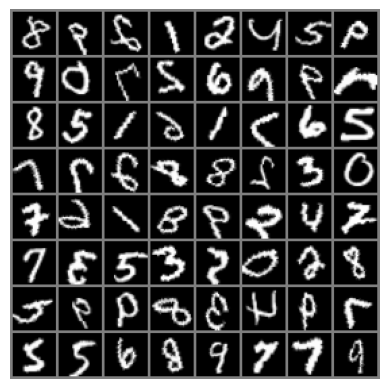

In [7]:
# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the batch and show images
grid_img = torchvision.utils.make_grid(images)
imshow(grid_img)

**Data augmentation** is a powerful technique that increases the variability of the training data without actually requiring more real data.
+ By applying random transformations—such as rotations, flips, and random crops—the model is exposed to many different "views" of the same data.
+ In other words, rather than memorizing specific positions or orientations of objects, the model learns robust features that are effective even when the input images are perturbed

#### convolutional neural network (CNN) trained on MNIST data with and without augmentation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transformations
# Transformation without augmentation (only resizing and normalization)
transform_no_aug = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformation with augmentation (includes random rotations, flips, and cropping)
transform_aug = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST datasets
train_dataset_no_aug = datasets.MNIST(root='./data', train=True, download=True, transform=transform_no_aug)
train_dataset_aug    = datasets.MNIST(root='./data', train=True, download=True, transform=transform_aug)
test_dataset         = datasets.MNIST(root='./data', train=False, download=True, transform=transform_no_aug)

# Create data loaders
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=64, shuffle=True)
train_loader_aug    = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader         = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN for MNIST classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool  = nn.MaxPool2d(2)
        # Calculate the size after two conv+pool layers.
        # For input size 32x32: after two rounds of conv and pool, feature map size is roughly 6x6.
        self.fc1   = nn.Linear(64 * 6 * 6, 128)
        self.fc2   = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Training function
def train_model(model, train_loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Training and evaluating the model without data augmentation
print("Training on non-augmented data:")
model_no_aug = SimpleCNN()
optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model_no_aug, train_loader_no_aug, optimizer_no_aug, criterion, epochs=10)
acc_no_aug = evaluate_model(model_no_aug, test_loader)
print("Test Accuracy (No Augmentation): {:.2f}%\n".format(acc_no_aug * 100))

# Training and evaluating the model with data augmentation
print("Training on augmented data:")
model_aug = SimpleCNN()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

train_model(model_aug, train_loader_aug, optimizer_aug, criterion, epochs=10)
acc_aug = evaluate_model(model_aug, test_loader)
print("Test Accuracy (With Augmentation): {:.2f}%".format(acc_aug * 100))

Training on non-augmented data:
Epoch 1/10, Loss: 0.1524
Epoch 2/10, Loss: 0.0455
Epoch 3/10, Loss: 0.0305
Epoch 4/10, Loss: 0.0230
Epoch 5/10, Loss: 0.0178
Epoch 6/10, Loss: 0.0135
Epoch 7/10, Loss: 0.0112
Epoch 8/10, Loss: 0.0094
Epoch 9/10, Loss: 0.0083
Epoch 10/10, Loss: 0.0069
Test Accuracy (No Augmentation): 99.08%

Training on augmented data:
Epoch 1/10, Loss: 0.5198
Epoch 2/10, Loss: 0.2264
Epoch 3/10, Loss: 0.1732
Epoch 4/10, Loss: 0.1481
Epoch 5/10, Loss: 0.1313
Epoch 6/10, Loss: 0.1206
Epoch 7/10, Loss: 0.1119
Epoch 8/10, Loss: 0.1053
Epoch 9/10, Loss: 0.1009
Epoch 10/10, Loss: 0.0952
Test Accuracy (With Augmentation): 98.18%


+ The model trained on **augmented data** may initially have a slightly **higher training loss** or **lower training accuracy** because the task is effectively harder—the model must learn to handle a wide variety of input variations.
+ However, the model trained on augmented data tends to **generalize better on unseen test data**, resulting in **improved test accuracy** compared to the model trained on non-augmented data.